T dim 18
x_dim 17


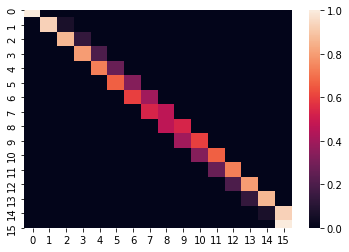

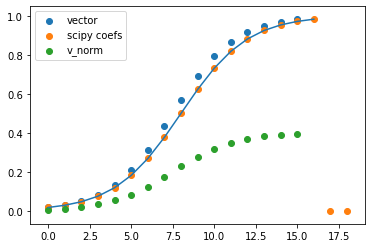

Condition number
 12730.232708648695
norm(yk) 2.485214974779029


In [2]:
from vqls import *
from utils import *
lower = 0.
upper = 1. 
n_step = 16
f_i = 0.0  
MAX_ITER = 100

nq=4
# K = 2^n = dim(T)-2
# with dim(S) = KxK
# n = num qubits
# T = set of knots

scaled=False

label = 'sigmoid'
func = sigmoid_t


x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
  norm = np.linalg.norm(y)
  y = y / norm
tck=splrep(x,y,k=1) #coeffs
#plt.scatter(range(len(tck[1])),tck[0], label = "scipy knots")


#############################################################################################
###################################### System Preparation ###################################
#############################################################################################

matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled);

import seaborn as sns

sns.heatmap(matrix)
plt.show()
plt.plot(y)

plt.scatter(range(len(vector)), vector, label="vector")
plt.scatter(range(len(tck[1])),tck[1], label="scipy coefs")
plt.scatter(range(len(v_norm)), v_norm, label="v_norm")
plt.legend()
plt.show()
#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################

k_numb=np.linalg.cond(np.array(matrix))
print('Condition number\n',k_numb)
print('norm(yk)',np.linalg.norm(vector))




## asbgn


In [3]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 
q = vqls_circuit

In [4]:
import time
#weights = np.load("weights_8.npy")

Optimizing variational params..
Starting parameters = {w}
Cost at Step 0: 0.4982032
Cost at Step 1: 0.4730583
Cost at Step 2: 0.4812665
Cost at Step 3: 0.4490767
Cost at Step 4: 0.4901601
Cost at Step 5: 0.4788968
Cost at Step 6: 0.4593011
Cost at Step 7: 0.3069277
Cost at Step 8: 0.3498876
Cost at Step 9: 0.3355311
Cost at Step 10: 0.2962658
Cost at Step 11: 0.3735104
Cost at Step 12: 0.3769412
Cost at Step 13: 0.3905516
Cost at Step 14: 0.1231001
Cost at Step 15: 0.1952474
Cost at Step 16: 0.0984012
Cost at Step 17: 0.0444998
Cost at Step 18: 0.0668124
Cost at Step 19: 0.0670080
Cost at Step 20: 0.0419099
Cost at Step 21: 0.1595177
Cost at Step 22: 0.0360058
Cost at Step 23: 0.1310716
Cost at Step 24: 0.0262270
Cost at Step 25: 0.1557685
Cost at Step 26: 0.0553910
Cost at Step 27: 0.0952858
Cost at Step 28: 0.0381865
Cost at Step 29: 0.0344412
Cost at Step 30: 0.0505065
Cost at Step 31: 0.0388926
Cost at Step 32: 0.0203909
Cost at Step 33: 0.0349266
Cost at Step 34: 0.0180028
Cost at

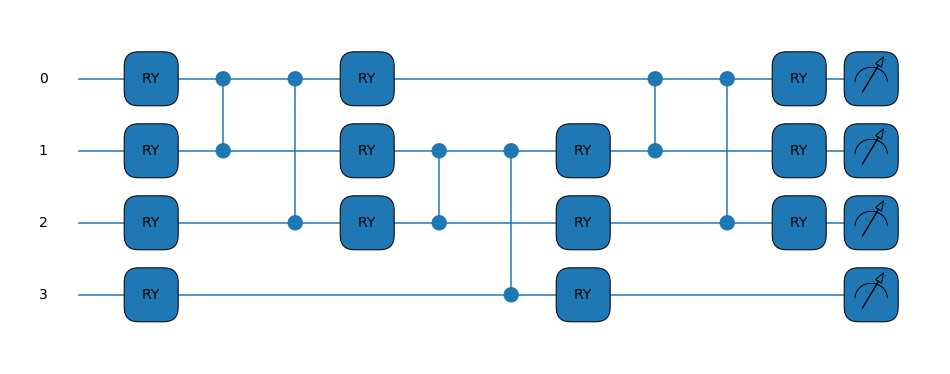

In [5]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

print('Optimizing variational params..')
start = time.time()
weights = vqls_circuit.train(max_iter=MAX_ITER)  
end = time.time()
print("The time of execution of above program is :", end-start)
q = vqls_circuit.solution(weights, True)
print('Quantum coefficients         :',q)
print("Variational Circuit's weights:",weights)


In [6]:
np.save(f"weights_{n_step}_{MAX_ITER}", weights)

(<Figure size 936x360 with 1 Axes>, <matplotlib.axes._axes.Axes object at 0x7efe7ce6d250>)


tensor([-0.01947198+0.j, -0.01522519+0.j, -0.02271326+0.j,
        -0.0256207 +0.j, -0.07189905+0.j, -0.10903766+0.j,
        -0.11469609+0.j, -0.11347549+0.j, -0.25668907+0.j,
        -0.29197073+0.j, -0.31148153+0.j, -0.33033558+0.j,
        -0.34969566+0.j, -0.36780721+0.j, -0.3869223 +0.j,
        -0.43654275+0.j], requires_grad=True)

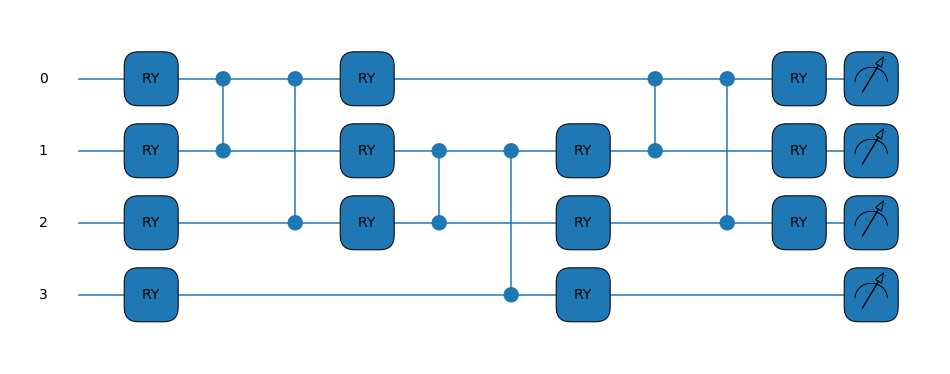

In [17]:
q = vqls_circuit.solution(weights, True)
q

## aosiegn


In [12]:
#Classic beta coefficients
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
print('beta  qunatum')
y_c=np.dot(matrix,c) #classic


y_q=np.dot(matrix,q) #hybrid
                     #Quantum
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))
  break
rss_full = np.sum(np.square(np.array(y_c) - np.array(y_fq)))
rss_hybr = np.sum(np.square(np.array(y_c) - np.array(y_q)))

print('RSS_q:',rss_full)
print('RSS_h:',rss_hybr)



beta_classic                 : [ 1.79862100e-02  4.02018812e-02 -1.08690957e-01  1.08546744e+00
 -3.92600627e+00  1.12987468e+01 -2.19716681e+01  3.37325659e+01
 -3.76220919e+01  3.39810949e+01 -2.15041058e+01  1.19391401e+01
 -3.16049806e+00  1.93615865e+00  7.97671560e-01  9.82013790e-01]
RSS_q: 14.099381460503672
RSS_h: (12.534970170685417+0j)


In [9]:
len(y_fq)

16

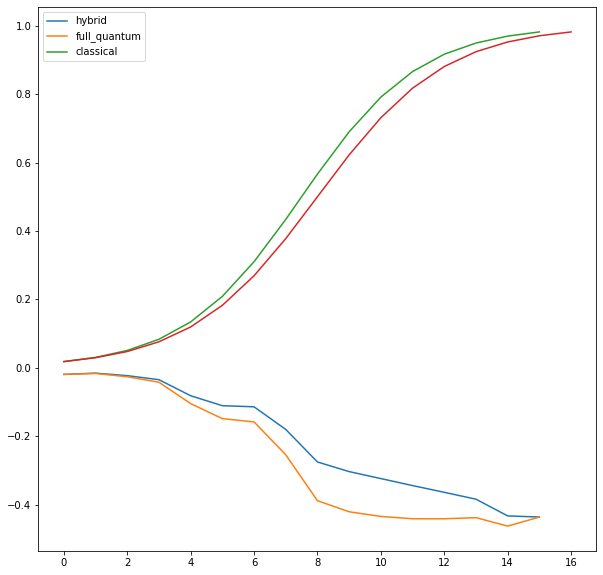

In [16]:
plt.figure(figsize=(10,10))
plt.plot(range(len(y_fq)),y_q,label= "hybrid")
plt.plot(range(len(y_fq)),y_fq, label="full_quantum")
plt.plot(range(len(y_fq)),y_c, label="classical")
plt.plot(y)
plt.legend()

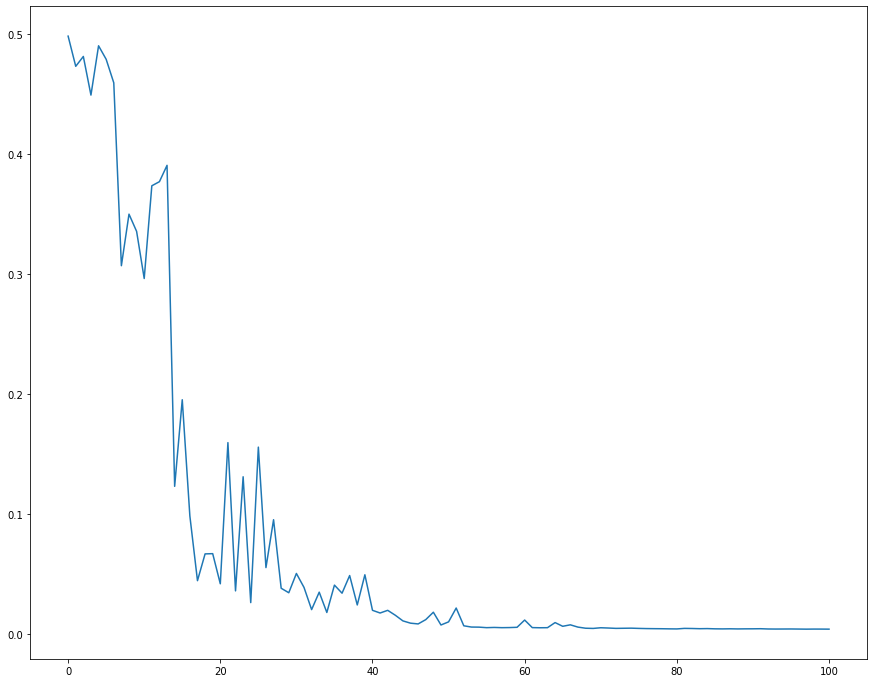

In [15]:
plt.figure(figsize=(15,12))
plt.plot(vqls_circuit.cost_vals);